# Solutions 7 - Examples in Sparse + Low-Rank Splitting

---

## Assignment 1

We need functions from the notebook 
[L3 Sparse + Low-Rank Splitting](L3 Sparse + Low-Rank Splitting.ipynb).

In [1]:
# Shrinkage
function Shr{T}(x::Array{T},τ::T)
    sign(x).*max(abs(x)-τ,0)
end

# Singular value thresholding
function D{T}(A::Array{T}, τ::T)
    # U,σ,V=svd(A)
    # This can be replaced by even faster approach using Gram matrix
    G=A'*A
    u,σ,V=svd(G)
    σ=sqrt(σ)
    S=Shr(σ,τ)
    k=sum(S.>zero(T))
    # U[:,1:k]*diagm(S[1:k])*V[:,1:k]'
    H=V[:,1:k]*diagm(S[1:k]./σ[1:k])*V[:,1:k]'
    A*H
end

function PCPAD{T}(A::Array{T})
    # Initialize
    δ=1.0e-7
    tol=δ*vecnorm(A)
    m,n=size(A)
    S=zeros(A)
    Y=zeros(A)
    L=zeros(A)
    @show μ=(m*n)/(4*(norm(A[:],1)))
    μ1=one(T)/μ
    λ=1/sqrt(max(m,n))
    λμ1=λ*μ1
    ν=1e20
    maxiter=2000
    iterations=0
    # Iterate
    while (ν>tol) && iterations<maxiter
        iterations+=1
        L=D(A-S+μ1*Y,μ1)
        S=Shr(A-L+μ1*Y,λμ1)
        T=A-L-S
        Y=Y+μ*T
        ν=vecnorm(T)
    end
    L,S, iterations
end

PCPAD (generic function with 1 method)

In [2]:
# For compilation
A0=rand(3,3)
L,S,iter=PCPAD(A0)

μ = (m * n) / (4 * norm(A[:],1)) = 0.4167704487925698


(
3x3 Array{Float64,2}:
 0.338545  0.116833  0.314406
 0.782961  0.752023  0.528412
 0.63016   0.687743  0.391269,

3x3 Array{Float64,2}:
 0.0        -0.0   0.470755
 0.0         0.0   0.354238
 0.0313116   0.0  -0.0     ,

69)

In [3]:
rank(L), L+S-A0

(2,
3x3 Array{Float64,2}:
 -7.55318e-8   -6.63853e-8  0.0       
  7.41866e-8   -7.6147e-8   0.0       
 -1.11022e-16  -6.47158e-9  7.87606e-8)

In [4]:
using Images
using Colors
import ImageView

In [5]:
import VideoIO

  likely near C:\Users\Ivan\.julia\v0.4\VideoIO\src\avio.jl:17


In [6]:
whos(VideoIO)

                       VideoIO    159 KB     Module
                    opencamera   4432 bytes  Function
                     openvideo   1616 bytes  Function
                          play   1992 bytes  Function
                     playvideo    593 bytes  Function
                          pump   2450 bytes  Function
                          read     48 KB     Function
                         read!     13 KB     Function
                       viewcam   1503 bytes  Function


In [7]:
# Playing video in a Tk window
f = VideoIO.openvideo("files/visor.avi")

VideoReader(...)

In [8]:
VideoIO.playvideo(f)

LoadError: LoadError: Tk.TclError("bad window path name \".jl_win0.jl_ttk_frame1.jl_ttk_frame2\"")
while loading In[8], in expression starting on line 1

In [9]:
# Watch entire video, this time faster, and return 
# the number of frames.
f = VideoIO.openvideo("files/visor.avi")
img = read(f, Image)
canvas, _ = ImageView.view(img)
nframes=0
while !eof(f)
    nframes+=1
    read!(f,img)
    ImageView.view(canvas, img)
    sleep(1/100)
end
nframes

2291

In [10]:
# Let us get some information
typeof(img), size(img)

(Images.Image{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2,Array{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2}},(320,240))

In [11]:
# Now we will save frames without watching.
# Convert to Gray.
f = VideoIO.openvideo("files/visor.avi")
img = read(f, Image)
# canvas, _ = ImageView.view(img)
frames=Array(Images.Image{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2,
        Array{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2}},2291)
i=0
while !eof(f)
    i+=1
    read!(f,img)
    frames[i]=map(RGB,img)
    # ImageView.view(canvas, img)
    sleep(1/100)
end
i

2291

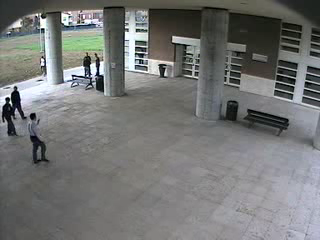

In [12]:
frames[1855]

In [13]:
typeof(frames[1800]), typeof(frames[1800].data)

(Images.Image{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2,Array{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2}},Array{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2})

In [14]:
# Make a shorter video for testing
img=frames[1]
canvas, _ = ImageView.view(img)
for i=1401:1450
    ImageView.view(canvas,frames[i])
    sleep(1/20)
end

In [15]:
# Turn frames into Gray and then into tall matrix matrix
mi,ni=size(frames[1])
m=mi*ni
n=50
A=Array(Float64,m,n)
for i=1:n
    a=convert(Image{Gray},frames[i+1400])
    A[:,i]=vec(float(a.data))
end

In [16]:
size(A)

(76800,50)

In [18]:
# For orientation
@time Q,R=qr(A);
@time D(A,0.5);

  0.182778 seconds (35 allocations: 58.661 MB)
  0.047103 seconds (83 allocations: 29.581 MB)


In [19]:
# Compute the splitting - 20 minutes
@time L,S,iters=PCPAD(A)

μ = (m * n) / (4 * norm(A[:],1)) = 0.5338641501542518
1111.755739 seconds (259.25 k allocations: 916.067 GB, 45.59% gc time)


(
76800x50 Array{Float64,2}:
 0.180392  0.180392  0.180392  0.180392  …  0.172549  0.172549  0.172549
 0.180392  0.180392  0.180392  0.180392     0.176471  0.176471  0.176471
 0.180392  0.180392  0.180392  0.180392     0.180392  0.180392  0.180392
 0.180392  0.180392  0.180392  0.180392     0.180392  0.180392  0.180392
 0.180392  0.180392  0.180392  0.180392     0.184313  0.184314  0.184314
 0.180392  0.180392  0.180392  0.180392  …  0.192157  0.192157  0.192157
 0.180392  0.180392  0.180392  0.180392     0.192157  0.192157  0.192157
 0.180392  0.180392  0.180392  0.180392     0.196078  0.196078  0.196078
 0.192157  0.192157  0.192157  0.192157     0.196078  0.196078  0.196078
 0.192157  0.192157  0.192157  0.192157     0.196078  0.196078  0.196078
 0.192157  0.192157  0.192157  0.192157  …  0.196078  0.196078  0.196078
 0.192157  0.192157  0.192157  0.192157     0.196078  0.196078  0.196078
 0.192157  0.192157  0.192157  0.192157     0.196078  0.196078  0.196078
 ⋮                    

In [20]:
# Reconstruct the low-rank video component
rank(L), norm(A-L-S)

(17,0.00010630086616956287)

In [21]:
svdvals(L)[1:20]

20-element Array{Float64,1}:
 992.554      
  15.3739     
  11.4257     
   9.9562     
   6.78189    
   3.92736    
   3.16958    
   2.4565     
   1.60181    
   0.785835   
   0.646874   
   0.601709   
   0.0213229  
   0.0150273  
   0.00339032 
   0.00197385 
   0.000177121
   1.66064e-13
   4.13613e-14
   4.12004e-14

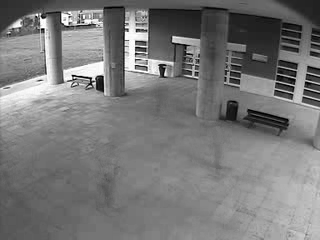

In [22]:
# How to restore the video?
v=L[:,1]
v1=reshape(v,mi,ni)'
v2=convert(Image{Gray},v1)

In [23]:
typeof(v2)

Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}}

In [24]:
Lframes=Array(Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}},n)
for i=1:n
    Lframes[i]=convert(Image{Gray},reshape(L[:,i],mi,ni)')
end

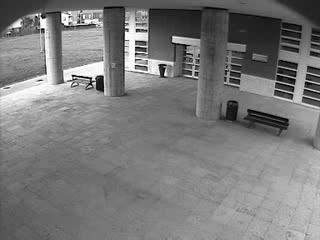

In [25]:
Lframes[40]

In [27]:
# Play the low-rank part
img=Lframes[1]
canvas, _ = ImageView.view(img)
for i=1:n
    # @show i
    ImageView.view(canvas,Lframes[i])
    sleep(1/20)
end
i

50

In [33]:
# Play the sparse part
Sframes=Array(Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}},n)
for i=1:n
    # Notice the +0.5
    Sframes[i]=convert(Image{Gray},reshape(S[:,i],mi,ni)')
end

img=Sframes[1]
canvas, _ = ImageView.view(img)
for i=1:n
    # @show i
    ImageView.view(canvas,Sframes[i]+0.3)
    sleep(1/20)
end

How to improve the visibility of the sparse component?